In [99]:
import hashlib
import os
import tarfile
import zipfile
import requests

DATA_HUB = dict()
DATA_HUB['url'] = 'http://d2l-data.s3-accelerate.amazonaws.com/'

def download(name, cache_dir=os.path.join('..', 'data')):
    assert name in DATA_HUB, f"{name} does not exist in {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname
    print(f"Downloading {fname} from {url}...")
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

In [100]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

DATA_HUB['kaggle_house_train'] = (DATA_HUB['url'] + 'kaggle_house_pred_train.csv',
                                    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (DATA_HUB['url'] + 'kaggle_house_pred_test.csv',
                                    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [101]:
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [102]:
test_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]]

,Id,MSSubClass,MSZoning,LotFrontage,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,2010,WD,Normal
1,1462,20,RL,81.0,2010,WD,Normal
2,1463,60,RL,74.0,2010,WD,Normal
3,1464,60,RL,78.0,2010,WD,Normal


In [103]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

#### 处理数据：normalization

In [104]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
all_features[numeric_features] = all_features[numeric_features].fillna(0)
all_features.shape

(2919, 79)

#### 处理离散值：one-hot encoding
- 将类别变量转化为多个二进制特征（0 或 1）。
- 每个类别对应一个新列，如果某一行属于该类别，则对应列的值为 1，否则为 0。

In [105]:
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 330)

In [106]:
n_train = train_data.shape[0]
all_features = all_features.replace({True: 1, False: 0})
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

In [107]:
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
    net = nn.Sequential(
        nn.Linear(in_features, 1)
        )
    return net

#### 将labels与预测值取对数进行计算，计算相对误差

In [108]:
def log_rmse(net, features, labels):
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(clipped_preds.log(), labels.log()))
    return rmse.item()

#### Adam优化器：自适应学习率？对学习率敏感程度较低

In [109]:
def train(net, train_features, train_labels, test_features, test_labels, num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [110]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        # Validation set / training set
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [111]:
def k_fold(k, x_train, y_train, num_epochs, learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, x_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate, weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls], xlabel='epoch', ylabel='rmse', legend=['train', 'valid'], yscale='log')
        print(f'fold {i + 1}, train log rmse {float(train_ls[-1]):f}, valid log rmse {float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

fold 1, train log rmse 0.169721, valid log rmse 0.156830
fold 2, train log rmse 0.162094, valid log rmse 0.188716
fold 3, train log rmse 0.163642, valid log rmse 0.168470
fold 4, train log rmse 0.168042, valid log rmse 0.154368
fold 5, train log rmse 0.163702, valid log rmse 0.182996
5-fold validation: avg train log rmse: 0.165440, avg valid log rmse: 0.170276


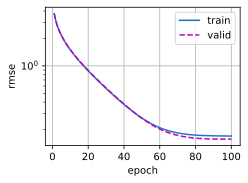

In [112]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print(f'{k}-fold validation: avg train log rmse: {float(train_l):f}, avg valid log rmse: {float(valid_l):f}')